In [1]:
# Standard library imports
import subprocess
import os

# Contributed library imports
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from pathlib import Path

# Our imports
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.geospatial import ensure_geometric_CRS
from multiview_mapping_toolkit.constants import (
    NULL_TEXTURE_INT_VALUE,
)
from multiview_mapping_toolkit.segmentation import (
    LookUpSegmentor,
    SegmentorPhotogrammetryCameraSet,
)

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [ ]:
short_model_name = "chips"
long_model_name = "ChipsB"
short_pred_name = "delta"
long_pred_name = "DeltaB"

In [2]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 0.25

## Python interpreter and script locations
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

FOLDER_TO_CITYSCAPES_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py"
VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
TRAIN_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/train.py"
INFERENCE_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/inference.py"

# One folder up from scripts
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()
SCRATCH_ROOT = Path(Path.home(), "scratch", "organized_str_disp_MVMT_experiments")

## Define the inputs
# The input labels
LABELS_FILENAME = Path(PROJECT_ROOT, "field_ref", "crowns_drone_w_field_data.geojson")

# The digital elevation map exported by Metashape
DTM_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "02_photogrammetry",
    "exports",
    "dtms",
    f"{short_model_name}.tif",
)
# The image folder used to create the Metashape project
IMAGE_FOLDER = f"/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/{long_model_name}"

## Define the intermediate results
LABELED_MESH_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "03_training_data",
    "labeled.ply",
)

# Where to save the rendering label images
RENDER_FOLDER = Path(
    SCRATCH_ROOT, "per_site_processing", short_model_name, "03_training_data", "renders"
)

TRAINING_DATA_FOLDER = Path(
    SCRATCH_ROOT,
    "per_site_processing",
    short_model_name,
    "03_training_data",
    f"{short_model_name}_80m_only_no_ground",
)
WORK_DIR = Path(
    PROJECT_ROOT, "models", "per_site", short_model_name, "80_meter_with_ground"
)


CHIPS_MESH_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    "chips",
    "02_photogrammetry",
    "exports",
    "meshes",
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219.ply",
)
# The camera file exported from Metashape
CHIPS_CAMERAS_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    "chips",
    "02_photogrammetry",
    "exports",
    "cameras",
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219_abs_paths.xml",
)
# The mesh exported from Metashape
DELTA_MESH_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    "delta",
    "02_photogrammetry",
    "exports",
    "meshes",
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746.ply",
)
# The camera file exported from Metashape
DELTA_CAMERAS_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    "delta",
    "02_photogrammetry",
    "exports",
    "cameras",
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746_abs_paths.xml",
)

PREDICTED_VECTOR_LABELS_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_pred_name,
    "05_processed_predictions",
    f"{short_pred_name}_80m_chips_model.geojson",
)
NUMPY_EXPORT_FACES_TEXTURE_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_pred_name,
    "05_processed_predictions",
    f"{short_pred_name}_80m_chips_model.npy",
)
PREDICTION_DTM_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_pred_name,
    "02_photogrammetry",
    "exports",
    "dtms",
    f"{short_pred_name}.tif",
)
TRAINING_IMAGES_NEAR_GT_FOLDER = Path()
INFERENCE_IMAGES_NEAR_GT_FOLDER = Path()
INFERENCE_PREDICTIONS_NEAR_GT_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_pred_name,
    "04_model_preds",
    "chips_80m_model",
    short_pred_name,
)

if short_model_name == "chips":
    # The mesh exported from Metashape
    INFERENCE_IMAGE_FOLDER = "/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/DeltaB/DeltaB_80m"
    PREDICTIONS_FOLDER = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/"
    MESH_FILENAME = CHIPS_MESH_FILENAME
    CAMERAS_FILENAME = CHIPS_CAMERAS_FILENAME
    PREDICTION_MESH_FILENAME = DELTA_MESH_FILENAME
    PREDICTION_CAMERAS_FILENAME = DELTA_CAMERAS_FILENAME
elif short_model_name == "delta":
    INFERENCE_IMAGE_FOLDER = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/images_near_labels/ChipsB_80m_2021_complete"
    PREDICTIONS_FOLDER = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/delta_80m_model/ChipsB_80m_2021_complete"
    MESH_FILENAME = DELTA_MESH_FILENAME
    CAMERAS_FILENAME = DELTA_CAMERAS_FILENAME
    PREDICTION_MESH_FILENAME = CHIPS_MESH_FILENAME
    PREDICTION_CAMERAS_FILENAME = CHIPS_CAMERAS_FILENAME

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

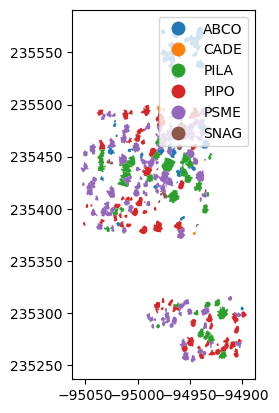

In [3]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
# Ensure that the CRS is geometric so we can buffer
gdf = ensure_geometric_CRS(gdf)

gdf.query(f"fire=='{short_model_name}'").plot(
    "species_observed", legend=True, vmin=0, vmax=9
)

# Load the mesh and read texture from geopolygon

In [4]:
# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        ROI=LABELS_FILENAME,
        ROI_buffer_meters=BUFFER_RADIUS_METERS,
        texture=LABELS_FILENAME,
        texture_column_name="species_observed",
        transform_filename=CAMERAS_FILENAME,
    )
    # Label the ground class
    mesh.label_ground_class(
        DTM_file=DTM_FILE,
        height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
        only_label_existing_labels=True,
        ground_class_name="ground",
        set_mesh_texture=True,
    )

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )
print(mesh.IDs_to_labels)
class_names = mesh.get_label_names()
print(f"class names {class_names}")

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/02_photogrammetry/exports/dtms/chips.tif: 100%|██████████| 520337/520337 [00:20<00:00, 25207.22it/s]


This method will be deprecated in favor f get_IDs_to_labels since it doesn't handle non-sequential indices
{0: 'ABCO', 1: 'CADE', 2: 'PILA', 3: 'PIPO', 4: 'PSME', 5: 'QUEV', 6: 'SNAG', 7: 'ground'}
This method will be deprecated in favor f get_IDs_to_labels since it doesn't handle non-sequential indices
class names ['ABCO', 'CADE', 'PILA', 'PIPO', 'PSME', 'QUEV', 'SNAG', 'ground']


# Load a set of cameras and downsample them to the region around annotations

In [ ]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

Loading GPS data for camera set: 100%|██████████| 25122/25122 [00:00<00:00, 2151755.30it/s]
/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


# Show the mesh

In [ ]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True)

# Render the labels onto the images

In [ ]:
mesh.save_renders_pytorch3d(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER,
)

# Show some of the rendered labels

In [ ]:
rendered_files = list(Path(RENDER_FOLDER).rglob("*.png"))

for rendered_file in rendered_files[:5]:
    image_file = Path(
        IMAGE_FOLDER, rendered_file.relative_to(RENDER_FOLDER)
    ).with_suffix(".JPG")
    image = imread(image_file)
    render = imread(rendered_file).astype(float)
    render[render == NULL_TEXTURE_INT_VALUE] = np.nan
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].imshow(render, vmin=0, vmax=9, cmap="tab10", interpolation="none")
    plt.show()
    plt.close()

# Format the training data

In [ ]:
class_names_str = " ".join(class_names)

subprocess.run(
    f"{MMSEG_UTILS_PYTHON} {FOLDER_TO_CITYSCAPES_SCRIPT} --images-folder {IMAGE_FOLDER}"
    + f" --labels-folder {RENDER_FOLDER} --output-folder {TRAINING_DATA_FOLDER} --classes {class_names_str} --remove-old",
    shell=True,
)

# Show some of the formatted example images

In [ ]:
cmap_file = Path(TRAINING_DATA_FOLDER, "colormap.png")
plt.imshow(imread(cmap_file))
plt.show()

vis_folder = Path(TRAINING_DATA_FOLDER, "vis")
vis_files = list(vis_folder.rglob("*JPG"))
for file in np.random.choice(vis_files, 10):
    print(f"showing {file}")
    plt.imshow(imread(file))
    plt.show()

# Train a model

In [ ]:
# Identify the config file as the only python file in the
config_file = list(Path(TRAINING_DATA_FOLDER).glob("*py"))[0]
subprocess.run(
    f"{MMSEG_PYTHON} {TRAIN_SCRIPT} {config_file} --work-dir {WORK_DIR}", shell=True
)

# Generate predictions with the model

In [ ]:
config_file = list(Path(WORK_DIR).glob("*py"))[0]
checkpoint_file = Path(WORK_DIR, "iter_10000.pth")
BATCH_SIZE = 2

subprocess.run(
    f"{MMSEG_PYTHON} {INFERENCE_SCRIPT} {config_file} {checkpoint_file} {INFERENCE_IMAGE_FOLDER} {PREDICTIONS_FOLDER} --batch-size {BATCH_SIZE}",
    shell=True,
)

# Visualize predictions

In [ ]:
# Add _vis to the folder name. Can't just add _vis to the str representation because it might have a trailing slash
pred_vis_dir = Path(
    Path(PREDICTIONS_FOLDER).parent, Path(PREDICTIONS_FOLDER).parts[-1] + "_vis"
)
STRIDE = 10

subprocess.run(
    f"{MMSEG_UTILS_PYTHON} {VIS_PREDS_SCRIPT} --image-dir {INFERENCE_IMAGE_FOLDER} --seg-dir {PREDICTIONS_FOLDER} --output-dir {pred_vis_dir} --stride {STRIDE}",
    shell=True,
)

# Aggregate predictions

In [ ]:
mesh = TexturedPhotogrammetryMesh(
    PREDICTION_MESH_FILENAME,
    transform_filename=PREDICTION_CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
print("Done creating mesh")

# Create camera set
camera_set = MetashapeCameraSet(PREDICTION_CAMERAS_FILENAME, INFERENCE_IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set = training_camera_set.get_cameras_in_folder(INFERENCE_IMAGE_FOLDER)
print("About to vis")
# %%
mesh.vis(camera_set=training_camera_set, force_xvfb=True)

# %%
segmentor = LookUpSegmentor(
    base_folder=INFERENCE_IMAGE_FOLDER,
    lookup_folder=PREDICTIONS_FOLDER,
    num_classes=8,
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

aggregated_face_labels, _, _ = mesh.aggregate_viewpoints_pytorch3d(
    segmentor_camera_set,
    image_scale=AGGREGATE_IMAGE_SCALE,
)

# %%
predicted_face_classes = np.argmax(
    aggregated_face_labels, axis=1, keepdims=True
).astype(float)
predicted_face_classes = mesh.label_ground_class(
    labels=predicted_face_classes,
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=PREDICTION_DTM_FILE,
    ground_ID=np.nan,
    set_mesh_texture=False,
)
np.save(NUMPY_EXPORT_FACES_TEXTURE_FILE, predicted_face_classes)
# %%
mesh.vis(
    vis_scalars=predicted_face_classes,
    force_xvfb=True,
)

mesh.export_face_labels_vector(
    face_labels=np.squeeze(predicted_face_classes),
    export_file=PREDICTED_VECTOR_LABELS_FILE,
    vis=True,
    vis_kwargs={"cmap": "tab10", "vmin": 0, "vmax": 9},
)

# Evaluate predictions

In [ ]:
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector

pred_gdf = gpd.read_file(PREDICTED_VECTOR_LABELS_FILE)
short_pred_name = "delta"
gt_gdf = gpd.read_file(LABELS_FILENAME).query(f"fire=='{short_pred_name}'")
pred_gdf.to_crs(gt_gdf.crs, inplace=True)
pred_gdf.plot("class_id", cmap="tab10", vmin=0, vmax=9)
gt_gdf.plot("species_observed", vmin=0, vmax=9)
counts_mat, inds_into_original = get_overlap_vector(
    unlabeled_df=gt_gdf, classes_df=pred_gdf, class_column="class_id"
)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

training_gdf = gpd.read_file(LABELS_FILENAME)
class_names = sorted(training_gdf["species_observed"].unique().tolist()) + ["ground"]
labeled_gt_gdf = gt_gdf.iloc[inds_into_original]

pred_class_IDs = np.argmax(counts_mat, axis=1)
pred_class_names = [class_names[ID] for ID in pred_class_IDs]

cf_matrix = confusion_matrix(
    y_true=labeled_gt_gdf["species_observed"].tolist(),
    y_pred=pred_class_names,
    labels=class_names,
)
cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=class_names)
cf_disp.plot()
plt.show()
accuracy = np.sum(cf_matrix * np.eye(cf_matrix.shape[0])) / np.sum(cf_matrix)
print(accuracy)